import data:

In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
df = pd.read_csv('C:\workdir\creditcard.csv')

skálázás ás metadata:

In [2]:
from sklearn.preprocessing import RobustScaler
from sdv.metadata import SingleTableMetadata

metadata = SingleTableMetadata()
scaler = RobustScaler()

df['amount_scaled'] = scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['time_scaled'] = scaler.fit_transform(df['Time'].values.reshape(-1,1))

df.drop(['Time','Amount'], axis=1, inplace=True)
df.head()

metadata.detect_from_dataframe(data=df)
metadata.validate()
python_dict = metadata.to_dict()
print(python_dict)

{'columns': {'V1': {'sdtype': 'numerical'}, 'V2': {'sdtype': 'numerical'}, 'V3': {'sdtype': 'numerical'}, 'V4': {'sdtype': 'numerical'}, 'V5': {'sdtype': 'numerical'}, 'V6': {'sdtype': 'numerical'}, 'V7': {'sdtype': 'numerical'}, 'V8': {'sdtype': 'numerical'}, 'V9': {'sdtype': 'numerical'}, 'V10': {'sdtype': 'numerical'}, 'V11': {'sdtype': 'numerical'}, 'V12': {'sdtype': 'numerical'}, 'V13': {'sdtype': 'numerical'}, 'V14': {'sdtype': 'numerical'}, 'V15': {'sdtype': 'numerical'}, 'V16': {'sdtype': 'numerical'}, 'V17': {'sdtype': 'numerical'}, 'V18': {'sdtype': 'numerical'}, 'V19': {'sdtype': 'numerical'}, 'V20': {'sdtype': 'numerical'}, 'V21': {'sdtype': 'numerical'}, 'V22': {'sdtype': 'numerical'}, 'V23': {'sdtype': 'numerical'}, 'V24': {'sdtype': 'numerical'}, 'V25': {'sdtype': 'numerical'}, 'V26': {'sdtype': 'numerical'}, 'V27': {'sdtype': 'numerical'}, 'V28': {'sdtype': 'numerical'}, 'Class': {'sdtype': 'numerical'}, 'amount_scaled': {'sdtype': 'numerical'}, 'time_scaled': {'sdtype'

In [3]:
X = df.drop('Class', axis=1)
y = df['Class']

#df = df.sample(frac=1)

#df_fraud = df.loc[df['Class'] == 1]
#df_not_fraud = df.loc[df['Class'] == 0]

#df_normal_dist = pd.concat([df_fraud, df_not_fraud])
#new_df = df_normal_dist.sample(frac=1)
#new_df.head()

Conditions:

In [5]:
from sdv.sampling import Condition

frauds = Condition(
    num_rows=25000,
    column_values={'Class': 1}
)

non_frauds = Condition(
    num_rows=25000,
    column_values={'Class': 0}
)

Generate CTGAN

In [6]:
from sdv.single_table import CTGANSynthesizer

"""ctgan_synthesizer = CTGANSynthesizer(metadata)
ctgan_synthesizer.fit(new_df)
ctgan_synthesizer.save(
    filepath='ctgan_synthesizer.pkl'
)
ctgan_df = ctgan_synthesizer.sample_from_conditions(conditions=[frauds,non_frauds])
ctgan_df.head()
"""

"ctgan_synthesizer = CTGANSynthesizer(metadata)\nctgan_synthesizer.fit(new_df)\nctgan_synthesizer.save(\n    filepath='ctgan_synthesizer.pkl'\n)\nctgan_df = ctgan_synthesizer.sample_from_conditions(conditions=[frauds,non_frauds])\nctgan_df.head()\n"

Load CTGAN

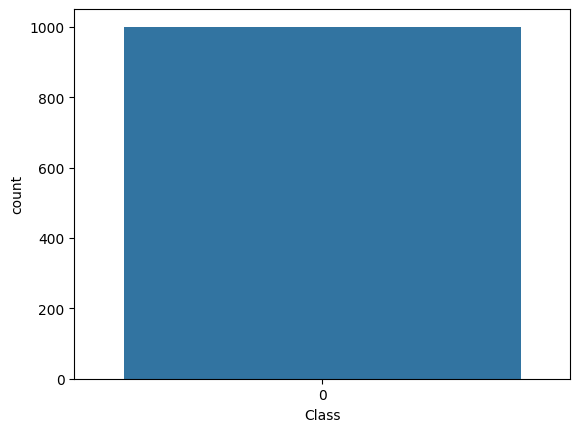

In [10]:
import pickle
import io
import torch

class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else: return super().find_class(module, name)

#contents = pickle.load(f) becomes...
ctgan_synthesizer = CPU_Unpickler(open("ctgan_synthesizer.pkl", "rb")).load()

#ctgan_synthesizer = CTGANSynthesizer.load(
#    filepath='ctgan_synthesizer.pkl', map_location='cpu'
#)
ctgan_df = ctgan_synthesizer.sample(1000)
ctgan_df.head()

import matplotlib.pyplot as plt
import seaborn as sns

#print('Csalas: ', ctgan_df['Class'].value_counts()[1])
#print('Nem csalas: ', ctgan_df['Class'].value_counts()[0])
sns.countplot(x=ctgan_df['Class'])
plt.show()


TVAE:

In [14]:
from sdv.single_table import TVAESynthesizer

"""tvae_synthesizer = TVAESynthesizer(metadata)
tvae_synthesizer.fit(new_df)

tvae_synthesizer.save(
    filepath='tvae_synthesizer.pkl'
)
tvae_df = tvae_synthesizer.sample_from_conditions(conditions=[frauds,non_frauds])
tvae_df.head()"""

"tvae_synthesizer = TVAESynthesizer(metadata)\ntvae_synthesizer.fit(new_df)\n\ntvae_synthesizer.save(\n    filepath='tvae_synthesizer.pkl'\n)\ntvae_df = tvae_synthesizer.sample_from_conditions(conditions=[frauds,non_frauds])\ntvae_df.head()"

TVAE load:

In [ ]:
"""tvae_synthesizer = TVAESynthesizer.load(
    filepath='tvae_synthesizer.pkl'
)"""
tvae_synthesizer = CPU_Unpickler(open("tvae_synthesizer.pkl", "rb")).load()

tvae_df = tvae_synthesizer.sample_from_conditions(conditions=[frauds,non_frauds])
tvae_df.head()

Evaluate the two synthetic dataframes:

In [16]:
from sdv.evaluation.single_table import evaluate_quality

quality_report_ctgan = evaluate_quality(
    real_data=df,
    synthetic_data=ctgan_df,
    metadata=metadata)

Creating report: 100%|██████████| 4/4 [00:29<00:00,  7.34s/it]



Overall Quality Score: 96.73%

Properties:
Column Shapes: 95.9%
Column Pair Trends: 97.57%


In [17]:
quality_report_tvae = evaluate_quality(
    real_data=df,
    synthetic_data=tvae_df,
    metadata=metadata)

Creating report: 100%|██████████| 4/4 [00:33<00:00,  8.47s/it]



Overall Quality Score: 95.4%

Properties:
Column Shapes: 93.33%
Column Pair Trends: 97.46%


In [18]:
from sdv.evaluation.single_table import get_column_plot

fig = get_column_plot(
    real_data=df,
    synthetic_data=ctgan_df,
    column_name='time_scaled',
    metadata=metadata
)
    
fig.show()

In [19]:
from sdv.evaluation.single_table import get_column_plot

fig = get_column_plot(
    real_data=df,
    synthetic_data=tvae_df,
    column_name='time_scaled',
    metadata=metadata
)
    
fig.show()

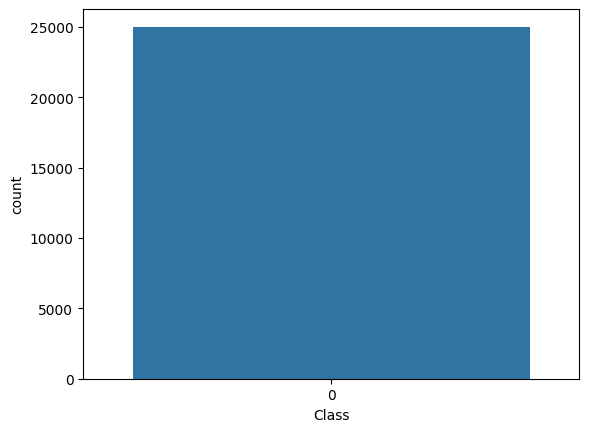

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

#print('Csalas: ', ctgan_df['Class'].value_counts()[1])
#print('Nem csalas: ', ctgan_df['Class'].value_counts()[0])
sns.countplot(x=ctgan_df['Class'])
plt.show()

Korreláció:

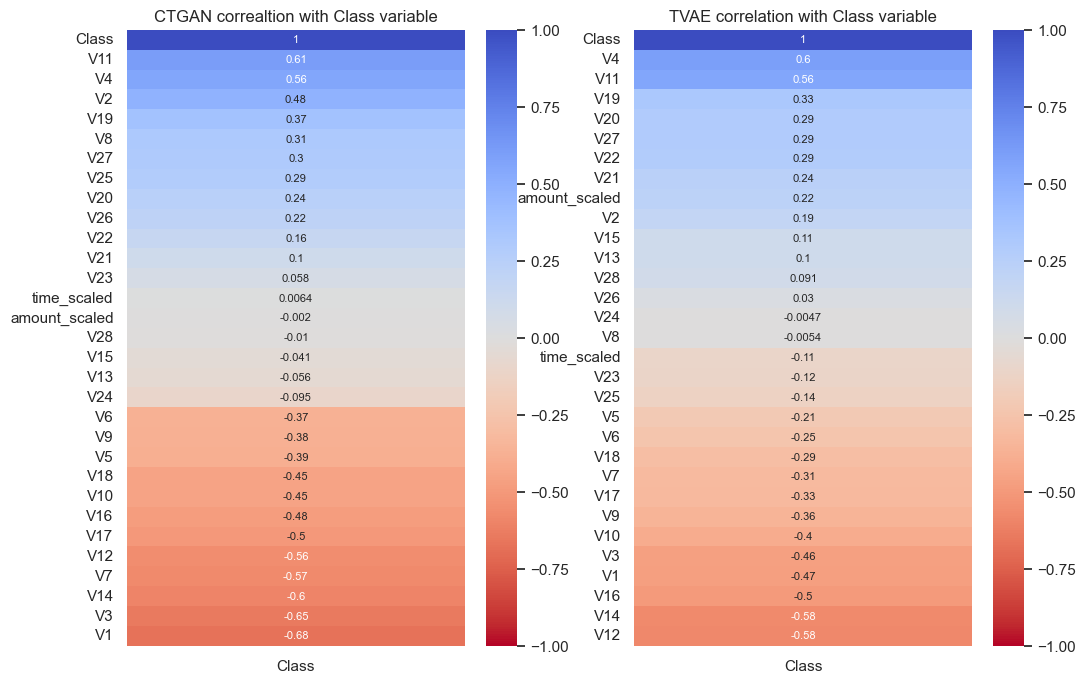

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,8))
sns.set(font_scale=0.6)
sns.set (rc = {'figure.figsize':(6, 8)})
ax1.set_title('CTGAN correaltion with Class variable')
sns.heatmap(ctgan_df.corr()[['Class']].sort_values(by='Class', ascending=False),vmin=-1, vmax=1, annot=True, annot_kws={'size': 8}, cmap='coolwarm_r',ax=ax1)
ax2.set_title('TVAE correlation with Class variable')
sns.heatmap(tvae_df.corr()[['Class']].sort_values(by='Class', ascending=False),vmin=-1, vmax=1, annot=True, annot_kws={'size': 8}, cmap='coolwarm_r', ax=ax2)
plt.show()

Training:

In [ ]:
from sklearn.model_selection import train_test_split
from collections import Counter

X_ctgan = ctgan_df.drop('Class', axis=1)
y_ctgan = ctgan_df['Class']
X_train, X_test, y_train, y_test = train_test_split(X_ctgan, y_ctgan, test_size=0.2)
print('Length of X (train): {} | Length of y (train): {}'.format(len(X_train), len(y_train)))
print('Length of X (test): {} | Length of y (test): {}'.format(len(X_test), len(y_test)))
print(Counter(y_train))
print(Counter(y_test))

Length of X (train): 40000 | Length of y (train): 40000
Length of X (test): 10000 | Length of y (test): 10000
Counter({1: 20019, 0: 19981})
Counter({0: 5019, 1: 4981})


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier

logreg_ctgan = LogisticRegression(n_jobs=-1)
dectree_ctgan = DecisionTreeClassifier()
svc_ctgan = LinearSVC()
knear_ctgan = KNeighborsClassifier(n_jobs=-1)

In [ ]:
logreg_ctgan.fit(X_train, y_train)
dectree_ctgan.fit(X_train,y_train)
svc_ctgan.fit(X_train,y_train)
knear_ctgan.fit(X_train,y_train)

KNeighborsClassifier(n_jobs=-1)

In [ ]:
from sklearn.metrics import accuracy_score

logreg_pred = logreg_ctgan.predict(X_test)
svc_pred = svc_ctgan.predict(X_test)
dectree_pred = dectree_ctgan.predict(X_test)
knear_pred = knear_ctgan.predict(X_test)
print("A logisztikus regresszió modellünk pontossági pontszáma jelenleg: ",accuracy_score(y_test, logreg_pred))
print("A Support Vector Machine modellünk pontossági pontszáma jelenleg: ",accuracy_score(y_test, svc_pred))
print("A Döntési fa modellünk pontossági pontszáma jelenleg: ",accuracy_score(y_test, dectree_pred))
print("A K közelebbi szomszéd modellünk pontossági pontszáma jelenleg: ",accuracy_score(y_test, knear_pred))

A logisztikus regresszió modellünk pontossági pontszáma jelenleg:  0.9465
A Support Vector Machine modellünk pontossági pontszáma jelenleg:  0.9456
A Döntési fa modellünk pontossági pontszáma jelenleg:  0.9258
A K közelebbi szomszéd modellünk pontossági pontszáma jelenleg:  0.9439


In [ ]:
X_tvae = tvae_df.drop('Class', axis=1)
y_tvae = tvae_df['Class']
X_train_tvae, X_test_tvae, y_train_tvae, y_test_tvae = train_test_split(X_tvae, y_tvae, test_size=0.2)
print('Length of X (train): {} | Length of y (train): {}'.format(len(X_train), len(y_train)))
print('Length of X (test): {} | Length of y (test): {}'.format(len(X_test), len(y_test)))
print(Counter(y_train))
print(Counter(y_test))

Length of X (train): 40000 | Length of y (train): 40000
Length of X (test): 10000 | Length of y (test): 10000
Counter({1: 20019, 0: 19981})
Counter({0: 5019, 1: 4981})


In [ ]:
logreg_tvae = LogisticRegression(n_jobs=-1)
dectree_tvae = DecisionTreeClassifier()
svc_tvae = LinearSVC()
knear_tvae = KNeighborsClassifier(n_jobs=-1)

logreg_tvae.fit(X_train_tvae, y_train_tvae)
dectree_tvae.fit(X_train_tvae,y_train_tvae)
svc_tvae.fit(X_train_tvae,y_train_tvae)
knear_tvae.fit(X_train_tvae,y_train_tvae)

logreg_pred = logreg_tvae.predict(X_test_tvae)
svc_pred = svc_tvae.predict(X_test_tvae)
dectree_pred = dectree_tvae.predict(X_test_tvae)
knear_pred = knear_tvae.predict(X_test_tvae)
print("A logisztikus regresszió modellünk pontossági pontszáma jelenleg: ",accuracy_score(y_test_tvae, logreg_pred))
print("A Support Vector Machine modellünk pontossági pontszáma jelenleg: ",accuracy_score(y_test_tvae, svc_pred))
print("A Döntési fa modellünk pontossági pontszáma jelenleg: ",accuracy_score(y_test_tvae, dectree_pred))
print("A K közelebbi szomszéd modellünk pontossági pontszáma jelenleg: ",accuracy_score(y_test_tvae, knear_pred))

A logisztikus regresszió modellünk pontossági pontszáma jelenleg:  0.9661
A Support Vector Machine modellünk pontossági pontszáma jelenleg:  0.9652
A Döntési fa modellünk pontossági pontszáma jelenleg:  0.9571
A K közelebbi szomszéd modellünk pontossági pontszáma jelenleg:  0.9761


RandomizedSearchCV:

In [ ]:
from sklearn.model_selection import RandomizedSearchCV


log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

grid_log_reg = RandomizedSearchCV(LogisticRegression(n_jobs=-1), log_reg_params)
grid_log_reg.fit(X_train_tvae, y_train_tvae)
print(grid_log_reg.best_params_)
logreg = grid_log_reg.best_estimator_

knears_params = {"n_neighbors": list(range(2,5,1)), 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}

grid_knears = RandomizedSearchCV(KNeighborsClassifier(n_jobs=-1), knears_params)
grid_knears.fit(X_train_tvae, y_train_tvae)
print(grid_knears.best_params_)
knear = grid_knears.best_estimator_

# Support Vector Classifier
svc_params = {"penalty": ['l1', 'l2'], 'C': [0.5, 0.7, 0.9, 1]}
grid_svc = RandomizedSearchCV(LinearSVC(), svc_params)
grid_svc.fit(X_train_tvae, y_train_tvae)
print(grid_svc.best_params_)

# SVC best estimator
svc = grid_svc.best_estimator_

# DecisionTree Classifier
tree_params = {"criterion": ["gini", "entropy"], "max_depth": list(range(2,4,1)), 
              "min_samples_leaf": list(range(5,7,1))}
grid_tree = RandomizedSearchCV(DecisionTreeClassifier(), tree_params)
grid_tree.fit(X_train_tvae, y_train_tvae)
print(grid_tree.best_params_)

# tree best estimator
dectree = grid_tree.best_estimator_

{'penalty': 'l2', 'C': 1000}
{'n_neighbors': 3, 'algorithm': 'brute'}
{'penalty': 'l2', 'C': 0.7}
{'min_samples_leaf': 5, 'max_depth': 3, 'criterion': 'gini'}


In [ ]:
logreg_pred = logreg.predict(X_test_tvae)
svc_pred = svc.predict(X_test_tvae)
dectree_pred = dectree.predict(X_test_tvae)
knear_pred = knear.predict(X_test_tvae)
print("A logisztikus regresszió modellünk pontossági pontszáma jelenleg: ",accuracy_score(y_test_tvae, logreg_pred))
print("A Support Vector Machine modellünk pontossági pontszáma jelenleg: ",accuracy_score(y_test_tvae, svc_pred))
print("A Döntési fa modellünk pontossági pontszáma jelenleg: ",accuracy_score(y_test_tvae, dectree_pred))
print("A K közelebbi szomszéd modellünk pontossági pontszáma jelenleg: ",accuracy_score(y_test_tvae, knear_pred))

A logisztikus regresszió modellünk pontossági pontszáma jelenleg:  0.9661
A Support Vector Machine modellünk pontossági pontszáma jelenleg:  0.9655
A Döntési fa modellünk pontossági pontszáma jelenleg:  0.9275
A K közelebbi szomszéd modellünk pontossági pontszáma jelenleg:  0.9752


In [ ]:
from sklearn.metrics import classification_report
print("Logreg: ")
print(classification_report(y_test_tvae,logreg_pred))
print("SVC: ")
print(classification_report(y_test_tvae,svc_pred))
print("Knear: ")
print(classification_report(y_test_tvae,knear_pred))
print("dectree: ")
print(classification_report(y_test_tvae,dectree_pred))

Logreg: 
              precision    recall  f1-score   support

           0       0.96      0.97      0.97      4981
           1       0.97      0.96      0.97      5019

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000

SVC: 
              precision    recall  f1-score   support

           0       0.96      0.97      0.97      4981
           1       0.97      0.96      0.97      5019

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000

Knear: 
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      4981
           1       0.98      0.98      0.98      5019

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     100

In [ ]:
from sklearn.metrics import roc_auc_score

logreg_pred = logreg.decision_function(X_test_tvae)
svc_pred = svc.decision_function(X_test_tvae)
dectree_pred = dectree.predict_proba(X_test_tvae)
knear_pred = knear.predict_proba(X_test_tvae)


print('Logistic Regression: ', roc_auc_score(y_test_tvae, logreg_pred))
print('Support Vector Classifier: ', roc_auc_score(y_test_tvae, svc_pred))
print('Decision Tree Classifier: ', roc_auc_score(y_test_tvae, dectree_pred[:,1]))
print('KNears Neighbors: ', roc_auc_score(y_test_tvae, knear_pred[:,1]))

Logistic Regression:  0.9937178692860325
Support Vector Classifier:  0.9935047062079577
Decision Tree Classifier:  0.9583304382915289
KNears Neighbors:  0.9887822180152281


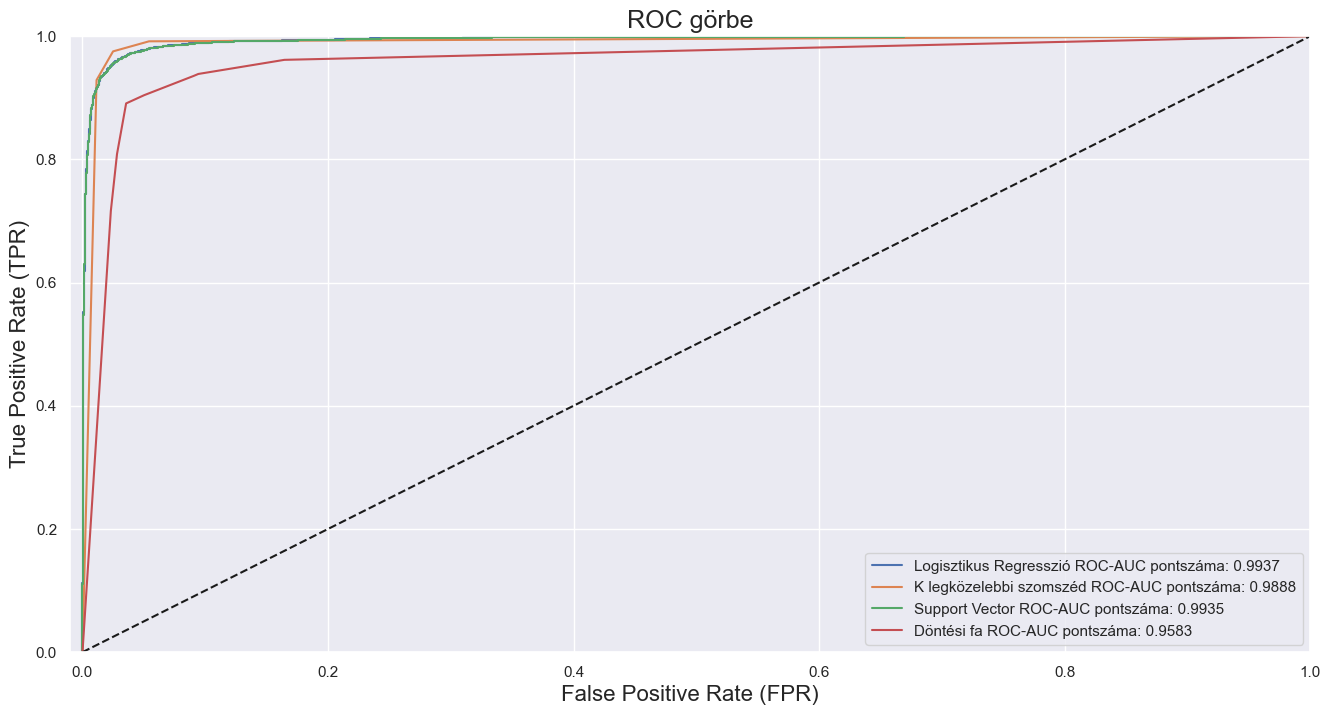

In [ ]:
from sklearn.metrics import roc_curve
log_fpr, log_tpr, log_thresold = roc_curve(y_test_tvae, logreg_pred)
svc_fpr, svc_tpr, svc_threshold = roc_curve(y_test_tvae, svc_pred)
tree_fpr, tree_tpr, tree_threshold = roc_curve(y_test_tvae, dectree_pred[:,1])
knear_fpr, knear_tpr, knear_threshold = roc_curve(y_test_tvae, knear_pred[:,1])

def graph_roc_curve_multiple(log_fpr, log_tpr,knear_fpr, knear_tpr, svc_fpr, svc_tpr,tree_fpr, tree_tpr):
    plt.figure(figsize=(16,8))
    plt.title('ROC görbe', fontsize=18)
    plt.plot(log_fpr, log_tpr, label='Logisztikus Regresszió ROC-AUC pontszáma: {:.4f}'.format(roc_auc_score(y_test_tvae, logreg_pred)))
    plt.plot(knear_fpr, knear_tpr, label='K legközelebbi szomszéd ROC-AUC pontszáma: {:.4f}'.format(roc_auc_score(y_test_tvae, knear_pred[:,1])))
    plt.plot(svc_fpr, svc_tpr, label='Support Vector ROC-AUC pontszáma: {:.4f}'.format(roc_auc_score(y_test_tvae, svc_pred)))
    plt.plot(tree_fpr, tree_tpr, label='Döntési fa ROC-AUC pontszáma: {:.4f}'.format(roc_auc_score(y_test_tvae, dectree_pred[:,1])))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.01, 1, 0, 1])
    plt.xlabel('False Positive Rate (FPR)', fontsize=16)
    plt.ylabel('True Positive Rate (TPR)', fontsize=16)
   
    plt.legend()
    
graph_roc_curve_multiple(log_fpr, log_tpr,knear_fpr, knear_tpr, svc_fpr, svc_tpr, tree_fpr, tree_tpr)
plt.show()

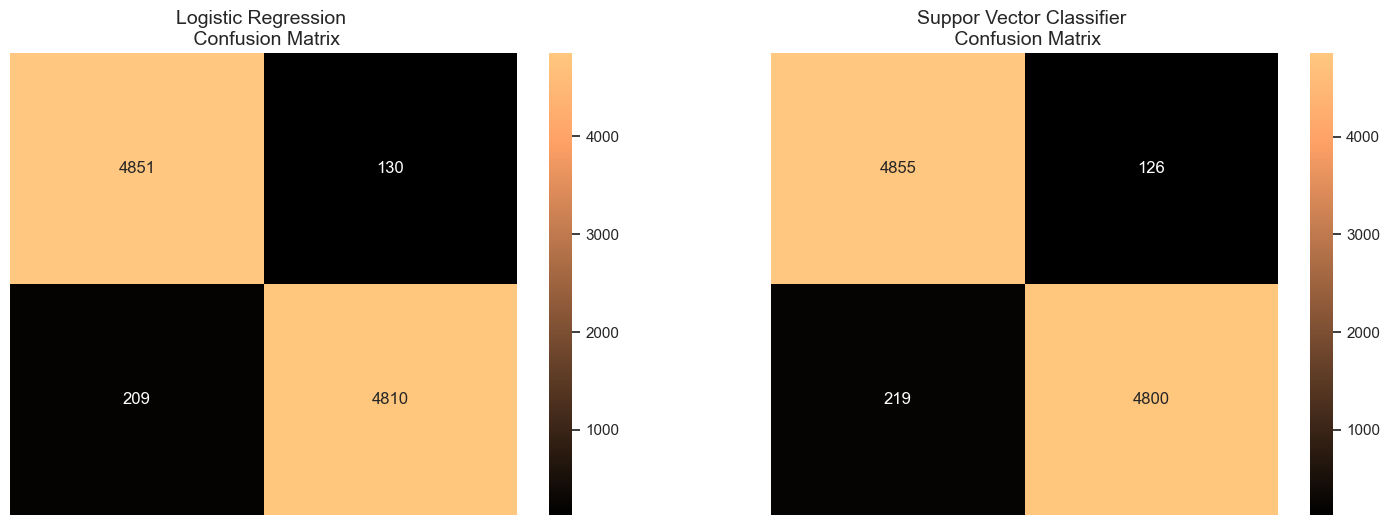

In [ ]:
from sklearn.metrics import confusion_matrix

y_pred_logreg = logreg.predict(X_test_tvae)
y_pred_svc = svc.predict(X_test_tvae)


log_reg_cf = confusion_matrix(y_test_tvae, y_pred_logreg)
svc_cf = confusion_matrix(y_test_tvae, y_pred_svc)

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(18,6))

sns.heatmap(log_reg_cf, ax=ax1, annot=True,fmt='g', cmap=plt.cm.copper)
ax1.set_title("Logistic Regression \n Confusion Matrix", fontsize=14)
ax1.set_xticklabels(['', ''], fontsize=14, rotation=90)
ax1.set_yticklabels(['', ''], fontsize=14, rotation=360)

sns.heatmap(svc_cf, ax=ax2, annot=True,fmt='g', cmap=plt.cm.copper)
ax2.set_title("Suppor Vector Classifier \n Confusion Matrix", fontsize=14)
ax2.set_xticklabels(['', ''], fontsize=14, rotation=90)
ax2.set_yticklabels(['', ''], fontsize=14, rotation=360)

plt.show()

[[279401   4914]
 [    54    438]]
[[279478   4837]
 [    56    436]]


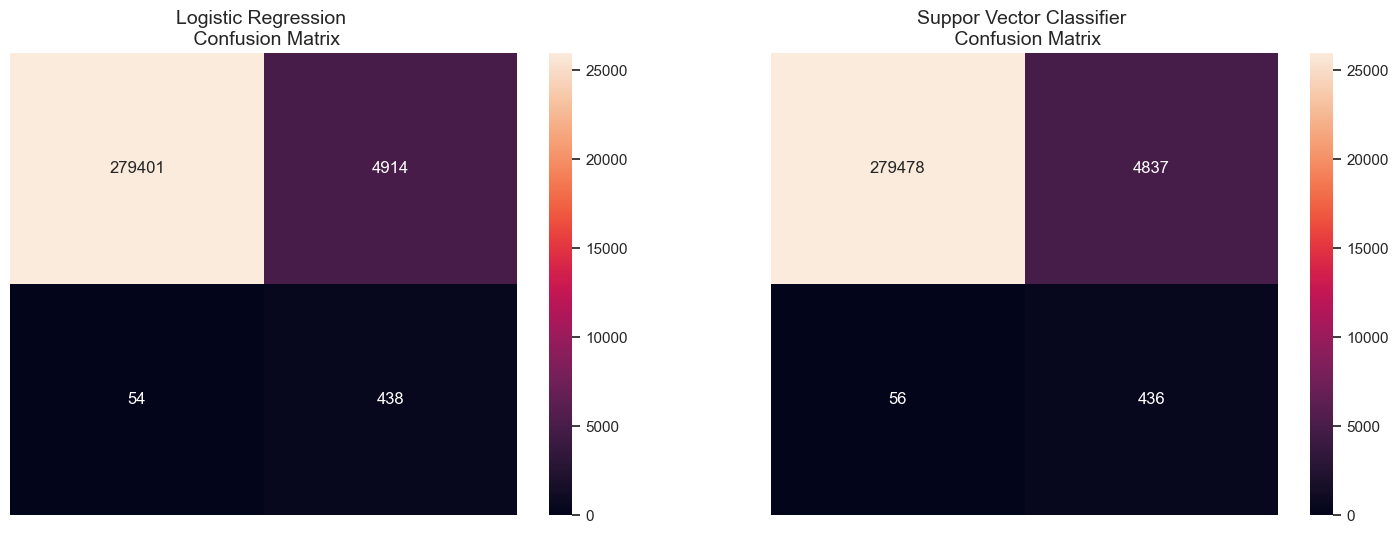

In [ ]:
from sklearn.metrics import confusion_matrix

y_pred_logreg_original = logreg.predict(X)
y_pred_svc_original = svc.predict(X)


log_reg_cf = confusion_matrix(y, y_pred_logreg_original)
svc_cf = confusion_matrix(y, y_pred_svc_original)

print(log_reg_cf)
print(svc_cf)

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(18,6))

sns.heatmap(log_reg_cf, ax=ax1,vmin=0, vmax=26000, annot=True, fmt='g')
ax1.set_title("Logistic Regression \n Confusion Matrix", fontsize=14)
ax1.set_xticklabels(['', ''], fontsize=8, rotation=90)
ax1.set_yticklabels(['', ''], fontsize=8, rotation=360)

sns.heatmap(svc_cf, ax=ax2,vmin=0,vmax=26000, annot=True, fmt='g')
ax2.set_title("Suppor Vector Classifier \n Confusion Matrix", fontsize=14)
ax2.set_xticklabels(['', ''], fontsize=8, rotation=90)
ax2.set_yticklabels(['', ''], fontsize=8, rotation=360)

plt.show()

In [ ]:
print(classification_report(y,y_pred_logreg_original))
print(classification_report(y,y_pred_svc_original))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99    284315
           1       0.08      0.89      0.15       492

    accuracy                           0.98    284807
   macro avg       0.54      0.94      0.57    284807
weighted avg       1.00      0.98      0.99    284807

              precision    recall  f1-score   support

           0       1.00      0.98      0.99    284315
           1       0.08      0.89      0.15       492

    accuracy                           0.98    284807
   macro avg       0.54      0.93      0.57    284807
weighted avg       1.00      0.98      0.99    284807

